In [22]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import json
import seaborn as sns
from random import randint, choice
from os import path
from main_data import (
    key_to_camelot,
    open_wheel,
    add_features,
    get_playlist,
    get_friendly,
    pickl,
    unpickl,
    sp,
)


In [23]:
# %store -r music_streams_no_features music_streams no_skip_df playlist_example
# music_streams_no_features, music_streams, no_skip_df, playlist_example = music_streams_no_features, music_streams, no_skip_df, playlist_example

In [24]:
# Import DataFrames generated by main_data.py
def imp():
    global all_streams, music_streams_no_features, music_streams, no_skip_df, playlist_example, podcasts, wheel_df
    (
        all_streams,
        music_streams_no_features,
        music_streams,
        no_skip_df,
        playlist_example,
        podcasts,
        wheel_df,
    ) = unpickl(
        "all_streams.p",
        "music_streams_no_features.p",
        "music_streams.p",
        "no_skip_df.p",
        "playlist_example.p",
        "podcasts.p",
        "wheel_df.p",
    )
    # return all_streams, music_streams_no_features, music_streams, no_skip_df, playlist_example, podcasts, wheel_df = import_all()

# todo: move to main

def hpm_rollback(pod):
    # refactoring of hpm() that works with pandas 1.4.2
    pod.loc[:, "hours"] = pod.loc[:, "playtime_s"].copy() / 3600
    pod.index = pod.timestamp
    podm = (
        pod.copy()
        .loc[:, "hours"]
        .resample("M")
        .apply(lambda x: np.sum(x.values))
        .round()
    )
    podm_gb = (
        podm.groupby(podm.index.strftime("%b"))
        .resample("Y")
        .apply(lambda x: np.sum(x.values))
        .round()
        .droplevel(level=1)
    )
    podm_gb = podm_gb.groupby(podm_gb.index).mean()
    return podm_gb


def hpm(df):
    df.loc[:, "hours"] = df.loc[:, "playtime_s"].copy() / 3600
    df = df.groupby(['month', pd.Grouper(key='timestamp', freq='Y')])['playtime_s'].sum().groupby("month").mean()
    return df

def plthpm(sgb):
    return sns.barplot(data=sgb.iloc[0:0], x=sgb.values, y=sgb.index)

# def plothpm(
#     plt.rcParams["figure.figsize"] = (8, 8)
# sns.barplot(data=podm_gb, x=podm_gb["hours"], y=podm_gb.index)
# )


def top_songs(years="all", skips=False, features=True):
    if skips and features:
        df = music_streams
    elif not skips:
        df = df.query("(playtime_s / duration_s) > 0.51").reset_index()
    # todo complete this

def format_td(td):
    """Converts timedelta to hh:mm:ss strictly for presentation purposes"""
    minutes, seconds = divmod(td.seconds + td.days * 86400, 60)
    hours, minutes = divmod(minutes, 60)
    return "{:d}:{:02d}:{:02d}".format(hours, minutes, seconds, td.microseconds)

In [25]:
imp()
# music_streams.timestamp = music_streams.timestamp.dt.tz_convert("America/New_York")
#todo convert abq listening to mountain

In [26]:

music_streams# I don't recall listening to this artist so much. Investigating if it was on repeat on accident or something.
why_tala = music_streams_no_features#.query('"Hope Tala" in artist')
why_why_tala = (
    why_tala.loc[:, ['playtime_s', 'timestamp']].groupby(by=why_tala.timestamp.dt.hour)
    .sum(numeric_only=True)
    .sort_values(by="playtime_s", ascending=False))
why_why_tala["playtime_s"] = why_why_tala["playtime_s"].apply(lambda x: x / 3600)
why_why_tala.head(50)


,playtime_s
timestamp,
0,217.660833
1,213.599722
2,200.713056
23,195.744722
4,177.740278
22,176.846111
21,174.491389
3,172.493056
5,161.819167


In [27]:
# Looks like I just let her run on most popular song repeat for a few hours.
music_streams_no_features.query('date == "11/27/2019"').sort_values(by="timestamp")


,timestamp,playtime_s,track,artist,album,id,start,end,shuffle,ddate,dtime,date,time,month,year,day
78510,2019-11-27 00:00:06-05:00,162,Blue,Hope Tala,Blue,2jNdYJVaPnG3I4XJApXnZy,trackdone,trackdone,False,2019-11-27,00:00:06,11/27/2019,00:00:06,Nov,2019,Wed
54104,2019-11-27 00:03:07-05:00,181,Valentine,Hope Tala,Starry Ache,4JoDBcODOajOx3ZRQlSa7o,trackdone,trackdone,False,2019-11-27,00:03:07,11/27/2019,00:03:07,Nov,2019,Wed
42212,2019-11-27 00:06:13-05:00,185,Sunburn,Hope Tala,Sensitive Soul,5jjTld8YpUHmBbr4SDYmo8,trackdone,trackdone,False,2019-11-27,00:06:13,11/27/2019,00:06:13,Nov,2019,Wed
83689,2019-11-27 00:08:18-05:00,122,Summer in Paris (Interlude),Hope Tala,Starry Ache,2XsYOvhSLUWgCTM10aZ4CV,trackdone,trackdone,False,2019-11-27,00:08:18,11/27/2019,00:08:18,Nov,2019,Wed
60470,2019-11-27 00:11:51-05:00,213,Eden,Hope Tala,Starry Ache,6ryhckbki35oQU9AS01JWI,trackdone,trackdone,False,2019-11-27,00:11:51,11/27/2019,00:11:51,Nov,2019,Wed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10584,2019-11-27 17:22:51-05:00,207,This Life,Denzel Curry,Imperial,2aQwdBWk4vSPWk1Csgtzdo,clickrow,trackdone,False,2019-11-27,17:22:51,11/27/2019,17:22:51,Nov,2019,Wed
44184,2019-11-27 17:26:54-05:00,243,Zenith,Denzel Curry,Imperial,67T0J1IDGgRwNMp3vWYaVb,trackdone,trackdone,False,2019-11-27,17:26:54,11/27/2019,17:26:54,Nov,2019,Wed
84067,2019-11-27 17:30:50-05:00,236,Good Night,Denzel Curry,Imperial,6bcnokzOVQxpn0quzHj6vc,trackdone,trackdone,False,2019-11-27,17:30:50,11/27/2019,17:30:50,Nov,2019,Wed
35559,2019-11-27 20:32:49-05:00,87,If Tomorrow's Not Here,Denzel Curry,Imperial,3oy9CClx1zCGnhzse9AvDu,trackdone,unexpected-exit-while-paused,False,2019-11-27,20:32:49,11/27/2019,20:32:49,Nov,2019,Wed


In [28]:
no_skip_df.query('artist.str.contains("(?i)miles davis")', engine="python")


,artist,track,album,duration_s,playtime_s,date,time,dtime,ddate,day,month,year,tempo,camelot,key_signature,start,end,shuffle,id,timestamp
697,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,450,09/30/2019,16:57:11,16:57:11,2019-09-30,Mon,Sep,2019,119,9B,G major,trackdone,trackdone,False,1q2Jzd23O49Crk91Rijl7Y,2019-09-30 16:57:11-05:00
698,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,449,05/28/2022,07:32:59,07:32:59,2022-05-28,Sat,May,2022,119,9B,G major,trackdone,endplay,True,1q2Jzd23O49Crk91Rijl7Y,2022-05-28 07:32:59-05:00
699,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,450,09/05/2021,03:45:02,03:45:02,2021-09-05,Sun,Sep,2021,119,9B,G major,trackdone,trackdone,True,1q2Jzd23O49Crk91Rijl7Y,2021-09-05 03:45:02-05:00
700,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,450,05/28/2021,19:22:10,19:22:10,2021-05-28,Fri,May,2021,119,9B,G major,playbtn,trackdone,False,1q2Jzd23O49Crk91Rijl7Y,2021-05-28 19:22:10-05:00
701,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,450,07/16/2021,20:09:49,20:09:49,2021-07-16,Fri,Jul,2021,119,9B,G major,clickrow,trackdone,False,1q2Jzd23O49Crk91Rijl7Y,2021-07-16 20:09:49-05:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47412,Miles Davis,Summertime - Mono Version,Porgy and Bess (Mono Version),199,199,02/20/2022,22:14:35,22:14:35,2022-02-20,Sun,Feb,2022,106,4A,F minor,clickrow,trackdone,False,0YRlrc4JzUCXHLS2j5keej,2022-02-20 22:14:35-05:00
47558,Miles Davis,Go Ahead John - part two C,Miles Ahead (Original Motion Picture Soundtrack),220,220,11/24/2019,20:48:15,20:48:15,2019-11-24,Sun,Nov,2019,122,3B,D-flat major,trackdone,trackdone,False,12hZQoeLnufiPI7l1CYfHn,2019-11-24 20:48:15-05:00
47593,Miles Davis,"Billy Boy (feat. John Coltrane, Cannonball Add...",Milestones (Mono),435,435,02/21/2022,18:36:48,18:36:48,2022-02-21,Mon,Feb,2022,134,8B,C major,trackdone,trackdone,False,5Jm4C3t6fn5WuRZQcjwvqx,2022-02-21 18:36:48-05:00
47602,Miles Davis,"So Near, So Far",Seven Steps To Heaven,417,417,01/24/2020,23:56:07,23:56:07,2020-01-24,Fri,Jan,2020,84,9B,G major,trackdone,trackdone,False,0CpyNb2RlzO7345kFiwXzg,2020-01-24 23:56:07-05:00


In [ ]:
def randyear(df):
    return choice(range(music_streams_no_features.timestamp.dt.year.min(), 
                        music_streams_no_features.timestamp.dt.year.max() +1))

In [ ]:
music_streams

In [ ]:
result = sp.search("Black Dove")
track = result['tracks']['items'][0]

artist = sp.artist(track["artists"][0]["external_urls"]["spotify"])
print("artist genres:", artist["genres"])
"""
how to aggregate playtime_s when results are lisre
of genres?

query genres for all tracks
"""

imp()
print(type([[artist["genres"]]]))
#genre = pd.DataFrame({"artist": "Teebs", "genre": artist["genres"]})
sorte = music_streams.sort_values(by="playtime_s")
genre = sorte.iloc[0:7, :]
print(genre)
genre["jenre"] = [[artist["genres"][0]]]
#genre = genre.explode("genre")
genre

#going to need to collapse into just artists and playtime_s before 
# exploding"

In [ ]:
music_streams.sort_values(by="playtime_s")

In [ ]:
def del_skips(deef):
    return deef.query("(playtime_s / duration_s) > 0.51").reset_index()

podcasts = podcasts.rename(columns={"episode": "track", "show": "artist"})

def top_songs(df, years=False, skips=False, rand=False):
    if not skips:
        df = del_skips(df) 
    if rand:
        years = randyear(df)
    elif years:
        cols = ["artist", "track", "year"]
    elif not years:
        years = df.timestamp.dt.year.unique()
        cols = ["artist", "track"]
    return pd.DataFrame(df.query("timestamp.dt.year in @years").pivot_table(columns=cols, aggfunc="size").sort_values(ascending=False))
    
    #todo works for artist if thats the omly col
    # make cols=[] and append based on conditions

top_songs(music_streams_no_features, skips=True).head(30)

#todo: 


In [ ]:
pivot_track = pd.DataFrame(
    no_skip_df.query('year == "2022"')
    .pivot_table(columns=["artist", "track", "year"], aggfunc="size")
    .sort_values(ascending=False))

pivot_track.head(30)


In [ ]:
no_skip_df.query('year == "2022"')


In [ ]:
# # Check for tracks missing from new df
# series1 = duration_s_prep['spotify_track_uri']
# series2 = local_features['uri']
# comparison = series1[~series1.isin(series2)]
# comparison


In [ ]:
# # Show missing track URLs for further investigation; track is likely removed or yet to be analyzed for audio_features.
# missing_tracks = []
# for i in range(len(comparison)):
#     missing_tracks.append(sp.track(comparison.iloc[i])['external_urls'])
# missing_tracks


In [ ]:
# Most played tracks
pivot_track = pd.DataFrame(
    no_skip_df.pivot_table(columns=["artist", "track"], aggfunc="size").sort_values(
        ascending=False
    )
)
pivot_track


In [ ]:
# Most listened to artists by number of songs played
pivot_artist = pd.DataFrame(
    no_skip_df.pivot_table(columns=["artist"], aggfunc="size").sort_values(
        ascending=False
    )
)
pivot_artist


In [ ]:
no_skip_df


In [ ]:
miles = no_skip_df.query('artist.str.contains("(?i)Miles Davis")')
pivot_miles = pd.pivot_table(miles, values="playtime_s", index=["album"], aggfunc="sum")
pivot_miles = pivot_miles.sort_values(by="playtime_s", ascending=False)
miles


In [ ]:
pivot_album_time = pd.pivot_table(
    no_skip_df, values="playtime_s", index=["album"], aggfunc="sum"
)


In [ ]:
pivot_album_time = pivot_album_time.sort_values(by="playtime_s", ascending=False)
pivot_album_time.head(20)


In [ ]:
pivot_artist_time = pd.pivot_table(
    no_skip_df, values="playtime_s", index=["artist"], aggfunc="sum"
)


In [ ]:
# print(pivot_artist_time.sort_values().to_string())
artist_time = pivot_artist_time.sort_values(
    by="playtime_s", ascending=False
).reset_index()
print(artist_time.to_string())


In [ ]:
# Artists played more than 10 mins
repeated_artists = artist_time[:1750]
# Number of unique tracks played from those artists

len(music_streams["track"].unique())


In [ ]:
still_repeated = repeated_artists["artist"]


In [ ]:
# Count number of unique tracks per artist and create ascending list
still_still_repeated = no_skip_df.query("artist in @still_repeated")
# still_still_repeated.loc[:, 'artist'] = still_still_repeated.copy().loc[:, 'artist'].astype(str)
group = still_still_repeated.groupby("artist")
songs_per_artist = group.apply(lambda x: x["track"].unique())
unique_songs = songs_per_artist.reset_index(name="unique_titles")


In [ ]:
unique_songs["unique_count"] = unique_songs.iloc[:, 1].str.len()


In [ ]:
unique_songs = unique_songs.sort_values(by="unique_count").reset_index()


In [ ]:
unique_export = unique_songs.query("unique_count <= 8")["artist"]


In [ ]:
pivot_artist_time.playtime_s


In [ ]:
# Artists with 10 or less songs played that I've heard more than an hour of. Indicative of artists I should explore more of.
pivot_artist_time.query("playtime_s > 3600000").query("artist in @unique_export")


Todo: Next step after the above is to plot least uniques with most ms played

In [ ]:
# Convert
pivot_artist_time["playtime_s"] = pd.to_timedelta(pivot_artist_time.playtime_s, unit="ms")


In [ ]:
def format_td(td):
    """Converts timedelta to hh:mm:ss strictly for presentation purposes"""
    minutes, seconds = divmod(td.seconds + td.days * 86400, 60)
    hours, minutes = divmod(minutes, 60)
    return "{:d}:{:02d}:{:02d}".format(hours, minutes, seconds, td.microseconds)


In [ ]:
pivot_artist_time["playtime_s"] = pivot_artist_time["playtime_s"].apply(format_td)


In [ ]:
# Show longest songs
no_skip_df.sort_values(by="playtime_s", axis=0, ascending=False)


In [33]:
music_streams

,artist,track,album,duration,playtime_s,date,time,dtime,ddate,day,month,year,tempo,camelot,key_signature,start,end,shuffle,id,timestamp
0,Rich Boy,Throw Some D's Remix,Rich Boy,351,351,03/25/2021,13:43:26,13:43:26,2021-03-25,Thu,Mar,2021,161,12A,D-flat minor,trackdone,trackdone,False,1qXLj4ywjsA0hGmaibmnn3,2021-03-25 13:43:26-05:00
1,Rich Boy,Throw Some D's Remix,Rich Boy,351,156,08/07/2021,00:06:29,00:06:29,2021-08-07,Sat,Aug,2021,161,12A,D-flat minor,clickrow,endplay,False,1qXLj4ywjsA0hGmaibmnn3,2021-08-07 00:06:29-05:00
2,Rich Boy,Throw Some D's Remix,Rich Boy,351,351,01/21/2021,00:42:09,00:42:09,2021-01-21,Thu,Jan,2021,161,12A,D-flat minor,trackdone,trackdone,False,1qXLj4ywjsA0hGmaibmnn3,2021-01-21 00:42:09-05:00
3,Rich Boy,Throw Some D's Remix,Rich Boy,351,0,10/18/2019,13:04:48,13:04:48,2019-10-18,Fri,Oct,2019,161,12A,D-flat minor,clickrow,endplay,False,1qXLj4ywjsA0hGmaibmnn3,2019-10-18 13:04:48-05:00
4,Rich Boy,Throw Some D's Remix,Rich Boy,351,2,02/17/2022,06:15:58,06:15:58,2022-02-17,Thu,Feb,2022,161,12A,D-flat minor,fwdbtn,fwdbtn,True,1qXLj4ywjsA0hGmaibmnn3,2022-02-17 06:15:58-05:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85407,James Blake,Frozen (feat. JID & SwaVay),Friends That Break Your Heart,236,236,09/29/2022,22:19:58,22:19:58,2022-09-29,Thu,Sep,2022,100,6B,B-flat major,trackdone,trackdone,False,4IX1G5Ibs3aWyiSLUO7OPt,2022-09-29 22:19:58-05:00
85408,Teitanblood,Anteinfierno,Death,297,297,09/24/2021,23:34:37,23:34:37,2021-09-24,Fri,Sep,2021,101,6A,G minor,clickrow,trackdone,False,2uFlPURngrcfsOz1nHgpaO,2021-09-24 23:34:37-05:00
85409,Xenia Rubinos,How Strange It Is,Black Terry Cat,192,192,12/05/2019,23:52:04,23:52:04,2019-12-05,Thu,Dec,2019,112,11B,A major,trackdone,trackdone,False,0ta023auUvOMAhzQ4oIRF9,2019-12-05 23:52:04-05:00
85410,Master P,Meal Ticket,I'm Bout It,244,244,01/18/2021,20:55:48,20:55:48,2021-01-18,Mon,Jan,2021,152,10B,D major,trackdone,trackdone,False,5TIGd8F70sI5mk6U4bubX8,2021-01-18 20:55:48-05:00


<AxesSubplot: ylabel='hours played'>

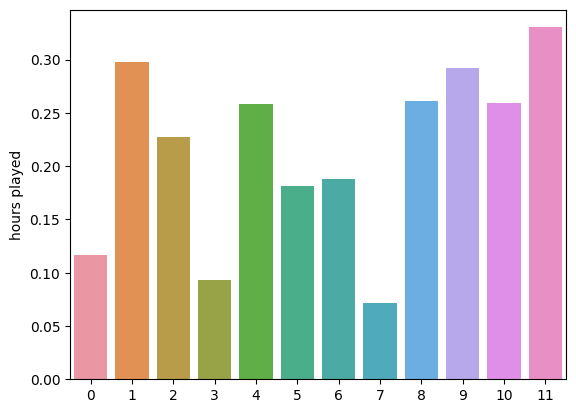

In [42]:
# How to control this for missing months? do october 25 2019 thru 2022
sns_prep = music_streams.query('year == "2019"| year == "2020" | year == "2021"')
sns_prep = pd.pivot_table(
    sns_prep,
    values="playtime_s",
    index=sns_prep.timestamp.dt.strftime("%b"),
    aggfunc="sum",
).reset_index()
sns_prep["hours played"] = sns_prep["playtime_s"].apply(lambda x: x / 3600000)
sns.barplot(data=sns_prep, x=sns_prep.index, y="hours played")


In [ ]:
# sum of unique uris closely maps to total skips per month
sns_prep = music_streams.copy().drop_duplicates(subset="id")
sns_prep["count"] = 1
sns_prep = (
    sns_prep.loc[:, ["month", "duration_s", "playtime_s", "shuffle", "count"]]
    .groupby(by="month")
    .sum(numeric_only=True)
)
sns.barplot(data=sns_prep, x=sns_prep.index, y="count")


In [ ]:
# good way to find months with most music discovery along with unique URIs
sns_prep = music_streams.copy().query("(playtime_s / duration_s) < 0.25")
sns_prep.at[:, "count"] = 1
sns_prep = (
    sns_prep.loc[:, ["month", "duration_s", "playtime_s", "shuffle", "count"]]
    .groupby(by="month")
    .sum(numeric_only=True)
)
sns.barplot(data=sns_prep, x=sns_prep.index, y="count")


In [ ]:
# common keys of listened tracks
no_skip_df.loc[:, "timestamp"] = no_skip_df.loc[:, "timestamp"].astype(str)
pivot_track = pd.DataFrame(
    no_skip_df.drop_duplicates(subset="timestamp")
    .pivot_table(columns=["key_signature"], aggfunc="size")
    .sort_values(ascending=False)
)
pivot_track


In [ ]:
# def show_transformations(df, song, transformation="all"):
#     song_key = df.query("(id == @song)")["camelot"]
#     # print(song_key)
#     keys = wheel_df.loc[transformation, song_key].reset_index(drop=True)
#     # print(type(keys))
#     print(keys[0])
#     return df.query("camelot.isin(@keys[0])", engine="python")


# fuck = show_transformations(music_streams, "115RufHm0zvrPN3MaheZ98", ["major"])
# fuck
# # song_key = playlist_example.loc[1, "camelot"]
# # friendkey = wheel_df.loc["dominant_relative", song_key]
# # playlist_example.query("camelot in @friendkey")


In [ ]:
# # This version works with uri
# #should also have function to get uri from song title + artist
# #todo: proper type hinting and default values
# # separate functions i suppose, maybe with decorators
# # https://stackoverflow.com/questions/62153371/best-way-to-create-python-function-with-multiple-options


get_friendly(
    music_streams, tempo_range=10, uri="5jh3f8fy8a335XYDyJ7x9R", shift=["all"]
).sort_values(by="track")


In [ ]:
# How often do I play songs with "birthday" in the name on my loved ones' birthdays?
music_streams.query("(playtime_s / duration_s) > 0.1").query(
    "track.str.contains('(?i)birthday')"
).sort_values(by=["month", "date"])


In [ ]:
# Todo: plot podcast listening vs music listening
# Totals per month
podcasts_2020 = podcasts.copy()
podcasts_2020["playtime_s"] = podcasts_2020["playtime_s"].copy() / 3600
podcast_per_month = podcasts_2020.groupby(by="month").sum(numeric_only=True)
podcast_per_month["playtime_s"]
sns.barplot(
    data=podcast_per_month, x=podcast_per_month["playtime_s"], y=podcast_per_month.index
)


In [ ]:
# Todo: plot podcast listening vs music listening
# damn i really spent most of january 2022 listening to podcats
# podm_gb = podm.groupby(by=podm.index).sum(numeric_only=True)

def plothpm(df_gb):
    sns.barplot(data=df_gb.iloc[0:0], x=df_gb.values, y=df_gb.index)

plothpm(hpm(no_skip_df))

In [ ]:
plothpm(hpm(music_streams))

In [ ]:
from main_data import unpickl
import pandas as pd
import numpy as np
import_all()
pod = podcasts.copy()

def custom_mean(df):
    return df.mean(skipna=True)

In [ ]:
# import_all()
#Todo: figure out which level of this 
pod = podcasts.copy()
pod.loc[:, "hours"] = podcasts.loc[:, "playtime_s"].copy() / 3600
pod.index = pod.timestamp
podm = pod.copy().loc[:,'hours'].resample("M").apply(lambda x: np.sum(x.values)).round()
podm_gb = podm.groupby(podm.index.strftime("%b")).resample("Y").apply(lambda x: np.sum(x.values)).round().droplevel(level=1)
podm_gb = podm_gb.groupby(podm_gb.index).mean()
podm_gb


In [ ]:
# avg per month

import matplotlib as plt
plt.rcParams['figure.figsize']=(8,8)
sns.barplot(data=podm_gb, x=podm_gb["hours"], y=podm_gb.index)

In [ ]:
def hpm(pod):
    #pod = podcasts.copy()
    pod.loc[:, "hours"] = pod.loc[:, "playtime_s"].copy() / 3600
    pod.index = pod.timestamp
    podm = pod.copy().loc[:,'hours'].resample("M").apply(lambda x: np.sum(x.values)).round()
    podm_gb = podm.groupby(podm.index.strftime("%b")).resample("Y").apply(lambda x: np.sum(x.values)).round().droplevel(level=1)
    podm_gb = podm_gb.groupby(podm_gb.index).mean()
    return podm_gb

podm_gb = hpm(podcasts)

In [ ]:
podm_gb